### Problem 1 : Data Science Challenge
- Goal: Predictive modeling and data visualization.

- Task:

    - Visualize the relation between features (you can design your own new features based on the given data)
    - Develop an ML model which, given the name of a director, predicts the release year of his next movie along with its probable genres
- Output: A GitHub repository with code, report or presentation that includes insights, methodologies, and conclusions.

- Evaluation: Accuracy of predictions, creativity in approach, clarity of presentation, and depth of insights.

- Data: Movie Metadata (./data/p1_movie_metadata.csv)

# IMPORTS

In [7]:
import os, csv 
import numpy as np
import pandas as pd
from datetime import datetime


In [8]:
# DATA PATH 
movie_csv_path = "../selection-problems/data/p1_movie_metadata.csv"

In [9]:
# READING AND PUTTING THE CSV DATA IN df
df = pd.read_csv(movie_csv_path)
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

# PRE-PROCESSING

### HELPER FUNCTIONS

In [5]:
def process_text(df_obj, columns=[]):
    category_label_map = {}
    for column in columns:
        print(column)
        unique_categories = sorted(df_obj[column].unique())
               
        _category_label_map = {category: i for i, category in enumerate(unique_categories)}

        # Replace 'MISSING' with a placeholder value (-1)
        if 'MISSING' in _category_label_map:
            _category_label_map['MISSING'] = -1
            # unique_categories.append(-1)
        category_label_map[column] = _category_label_map
        df_obj[f'{column}_label'] = df_obj[column].map(category_label_map[column])

        # df.drop(columns=[column], inplace=True) # WE CAN DROP THE COLUMN IF WE WANT
    
    return df_obj, category_label_map

def process_genre(df, genre_column='genres'):
    # Split the 'genre' column into separate columns
    genres = df[genre_column].str.get_dummies(sep='|')

    # Initialize new columns for each genre with 0 by default
    for genre in genres.columns:
        df[genre] = 0

    # Set values to 1 for each genre column if the movie belongs to that genre
    new_columns = []
    for index, row in df.iterrows():
        for genre in row[genre_column].split('|'):
            df.at[index, genre] = 1
            new_columns.append(genre)

    return df, sorted(list(set(new_columns)))


REMOVING NOT SO NECESSARY INFORMATION

In [6]:
df = df.drop(['movie_title', 'movie_imdb_link', 'plot_keywords'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  num_voted_users            5043 non-null   int64  
 12  cast_total_facebook_likes  5043 non-null   int64  
 13  actor_3_name               5020 non-null   objec

CHECKING FOR NaN

In [7]:
nan_columns = df.columns[df.isnull().any()]
nan_columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'actor_1_name', 'actor_3_name',
       'facenumber_in_poster', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'aspect_ratio'],
      dtype='object')

In [8]:
df = df.dropna()

In [9]:
nan_columns = df.columns[df.isnull().any()]
nan_columns

Index([], dtype='object')

In [10]:
# SEPARATING GENRES
df, new_genre_columns = process_genre(df, genre_column='genres')

In [11]:
new_genre_columns

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western']

##### CHANGING STRING DATA TO NUMBERS

In [12]:
string_columns = df.select_dtypes(include=['object']).columns
string_columns

Index(['color', 'director_name', 'actor_2_name', 'genres', 'actor_1_name',
       'actor_3_name', 'language', 'country', 'content_rating'],
      dtype='object')

In [13]:
df, processed_labels = process_text(df, string_columns)

color
director_name
actor_2_name
genres
actor_1_name
actor_3_name
language
country
content_rating


In [14]:
processed_labels

{'color': {' Black and White': 0, 'Color': 1},
 'director_name': {'Aaron Schneider': 0,
  'Aaron Seltzer': 1,
  'Abel Ferrara': 2,
  'Adam Goldberg': 3,
  'Adam Marcus': 4,
  'Adam McKay': 5,
  'Adam Rapp': 6,
  'Adam Rifkin': 7,
  'Adam Shankman': 8,
  'Adrian Lyne': 9,
  'Adrienne Shelly': 10,
  'Agnieszka Holland': 11,
  'Agnieszka Wojtowicz-Vosloo': 12,
  'Aki Kaurismäki': 13,
  'Akira Kurosawa': 14,
  'Akiva Goldsman': 15,
  'Akiva Schaffer': 16,
  'Alan Cohn': 17,
  'Alan J. Pakula': 18,
  'Alan Metter': 19,
  'Alan Parker': 20,
  'Alan Poul': 21,
  'Alan Rudolph': 22,
  'Alan Shapiro': 23,
  'Alan Taylor': 24,
  'Albert Brooks': 25,
  'Albert Hughes': 26,
  'Alejandro Agresti': 27,
  'Alejandro Amenábar': 28,
  'Alejandro G. Iñárritu': 29,
  'Alejandro Monteverde': 30,
  'Alessandro Carloni': 31,
  'Alex Craig Mann': 32,
  'Alex Garland': 33,
  'Alex Gibney': 34,
  'Alex Kendrick': 35,
  'Alex Proyas': 36,
  'Alex Rivera': 37,
  'Alex Smith': 38,
  'Alex Zamm': 39,
  'Alexander 

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3769 entries, 0 to 5042
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      3769 non-null   object 
 1   director_name              3769 non-null   object 
 2   num_critic_for_reviews     3769 non-null   float64
 3   duration                   3769 non-null   float64
 4   director_facebook_likes    3769 non-null   float64
 5   actor_3_facebook_likes     3769 non-null   float64
 6   actor_2_name               3769 non-null   object 
 7   actor_1_facebook_likes     3769 non-null   float64
 8   gross                      3769 non-null   float64
 9   genres                     3769 non-null   object 
 10  actor_1_name               3769 non-null   object 
 11  num_voted_users            3769 non-null   int64  
 12  cast_total_facebook_likes  3769 non-null   int64  
 13  actor_3_name               3769 non-null   object 
 1

##### ADDING EXTRA INFORMATION IN OUT DATAFRAME FOR MAKING MODEL

In [16]:
df['title_year_DateStamp'] = pd.to_datetime(df['title_year'], format='%Y')

df.sort_values(by=['director_name_label', 'title_year'], inplace=True)

df['time_since_last_release'] = df.groupby('director_name_label')['title_year_DateStamp'].diff().dt.days//365

current_year = datetime.now().year
df['time_since_last_release'].fillna(current_year - df['title_year_DateStamp'].dt.year, inplace=True)

df['number_of_movies'] = df.groupby('director_name_label').cumcount() + 1

df['release_frequency'] = df.groupby('director_name_label')['time_since_last_release'].transform('mean')

df['collaboration'] = df[['actor_1_name_label', 'actor_2_name_label', 'actor_2_name_label']].count(axis=1)

df['collaboration_likes'] = df[['actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes']].sum(axis=1)

# df['success'] = (df['gross'] - df['budget'])
df['success'] = (df['gross'] - df['budget'] > 0).astype(int)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3769 entries, 3497 to 3678
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   color                      3769 non-null   object        
 1   director_name              3769 non-null   object        
 2   num_critic_for_reviews     3769 non-null   float64       
 3   duration                   3769 non-null   float64       
 4   director_facebook_likes    3769 non-null   float64       
 5   actor_3_facebook_likes     3769 non-null   float64       
 6   actor_2_name               3769 non-null   object        
 7   actor_1_facebook_likes     3769 non-null   float64       
 8   gross                      3769 non-null   float64       
 9   genres                     3769 non-null   object        
 10  actor_1_name               3769 non-null   object        
 11  num_voted_users            3769 non-null   int64         
 12  cast_tot

In [18]:
# Select relevant features
features = ['director_name_label', 'director_facebook_likes','time_since_last_release', 'release_frequency', 'cast_total_facebook_likes', 'color_label', 'gross', 'success', 'movie_facebook_likes', 'content_rating_label']
target = 'title_year'
data = df[features + [target]].copy()

# VISUALIZATION

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3769 entries, 3497 to 3678
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   color                      3769 non-null   object        
 1   director_name              3769 non-null   object        
 2   num_critic_for_reviews     3769 non-null   float64       
 3   duration                   3769 non-null   float64       
 4   director_facebook_likes    3769 non-null   float64       
 5   actor_3_facebook_likes     3769 non-null   float64       
 6   actor_2_name               3769 non-null   object        
 7   actor_1_facebook_likes     3769 non-null   float64       
 8   gross                      3769 non-null   float64       
 9   genres                     3769 non-null   object        
 10  actor_1_name               3769 non-null   object        
 11  num_voted_users            3769 non-null   int64         
 12  cast_tot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


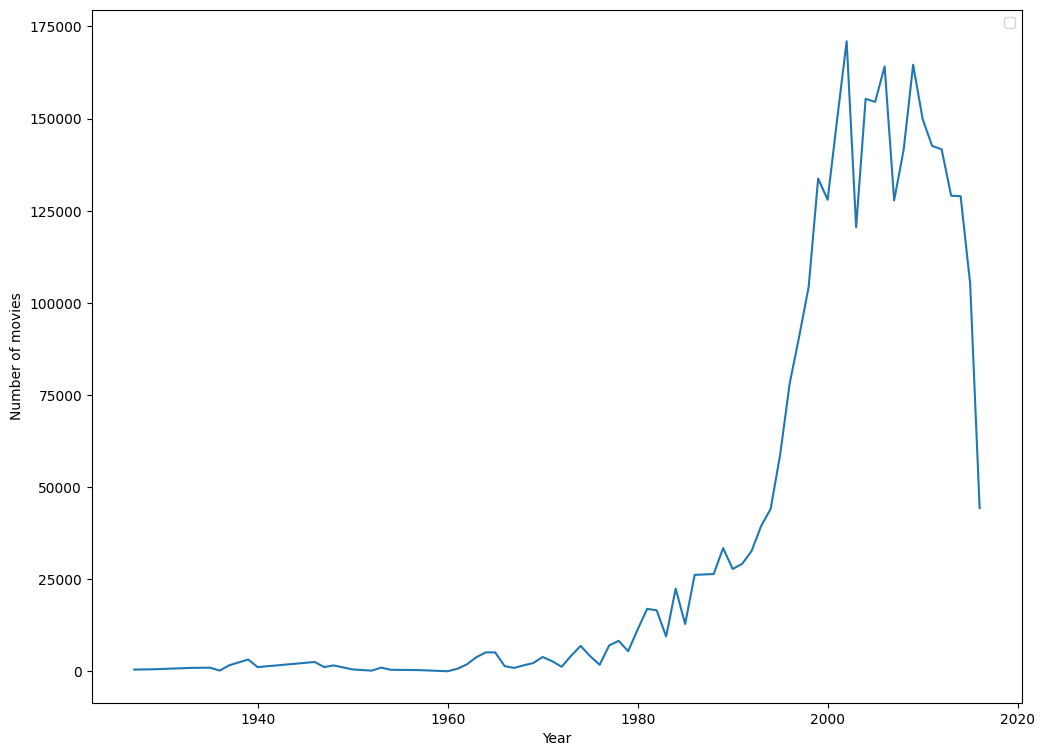

In [21]:
director_grouped = (df[['title_year', 'director_name_label']].groupby('title_year').sum())['director_name_label']

plt.figure(figsize=(12, 9))

plt.plot(sorted(df['title_year'].unique()), director_grouped)
plt.xlabel("Year")
plt.ylabel("Number of movies")
plt.legend()

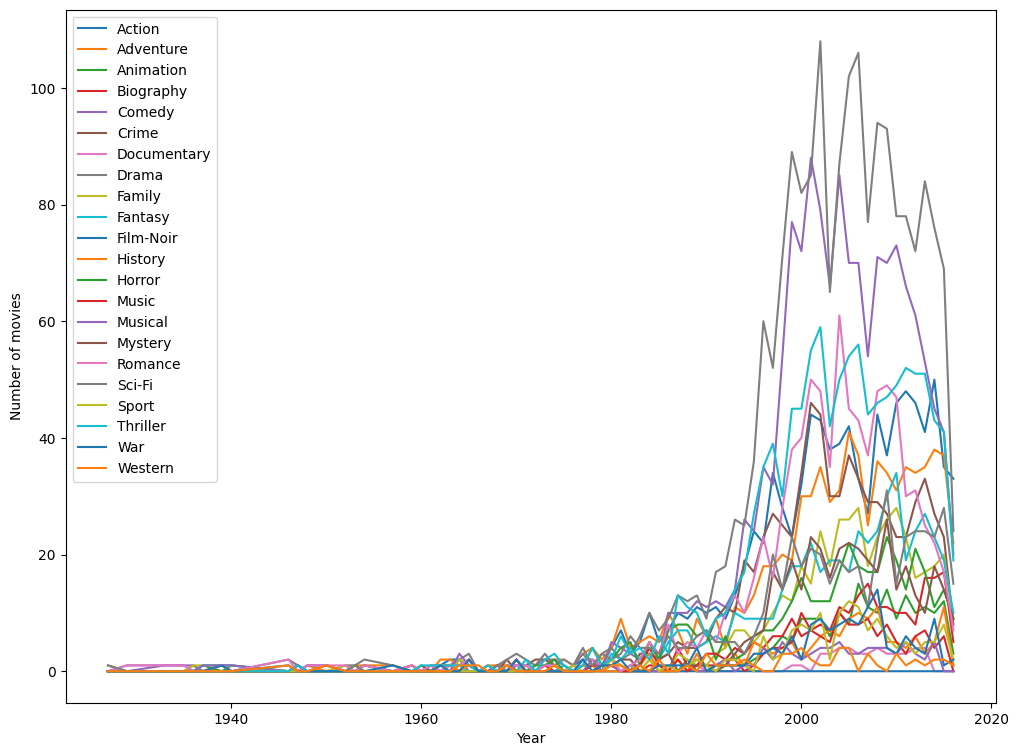

In [22]:
genre_grouped = (df[['title_year']+new_genre_columns].groupby('title_year').sum())[new_genre_columns]

plt.figure(figsize=(12, 9))

plt.plot(sorted(df['title_year'].unique()), genre_grouped, label = new_genre_columns)
plt.xlabel("Year")
plt.ylabel("Number of movies")
plt.legend()

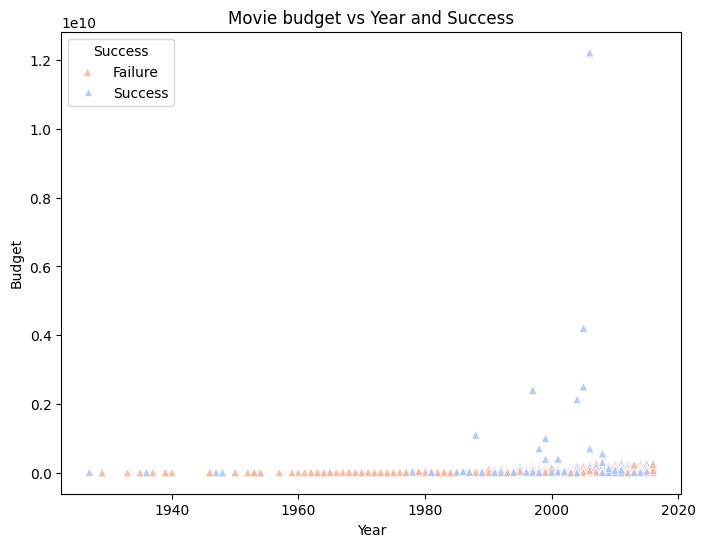

In [23]:
plt.figure(figsize=(8, 6))
# sns.scatterplot(data=df, x='movie_facebook_likes', y='success', hue='success', palette='coolwarm', alpha=0.7)
sns.scatterplot(data=df, 
                x='title_year', 
                y='budget', 
                hue='success', 
                palette='coolwarm', alpha=0.9,
                marker='^')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Budget')
plt.title('Movie budget vs Year and Success')

# Show legend
plt.legend(title='Success', 
        #    loc='upper right', 
           labels=['Failure', 'Success'])


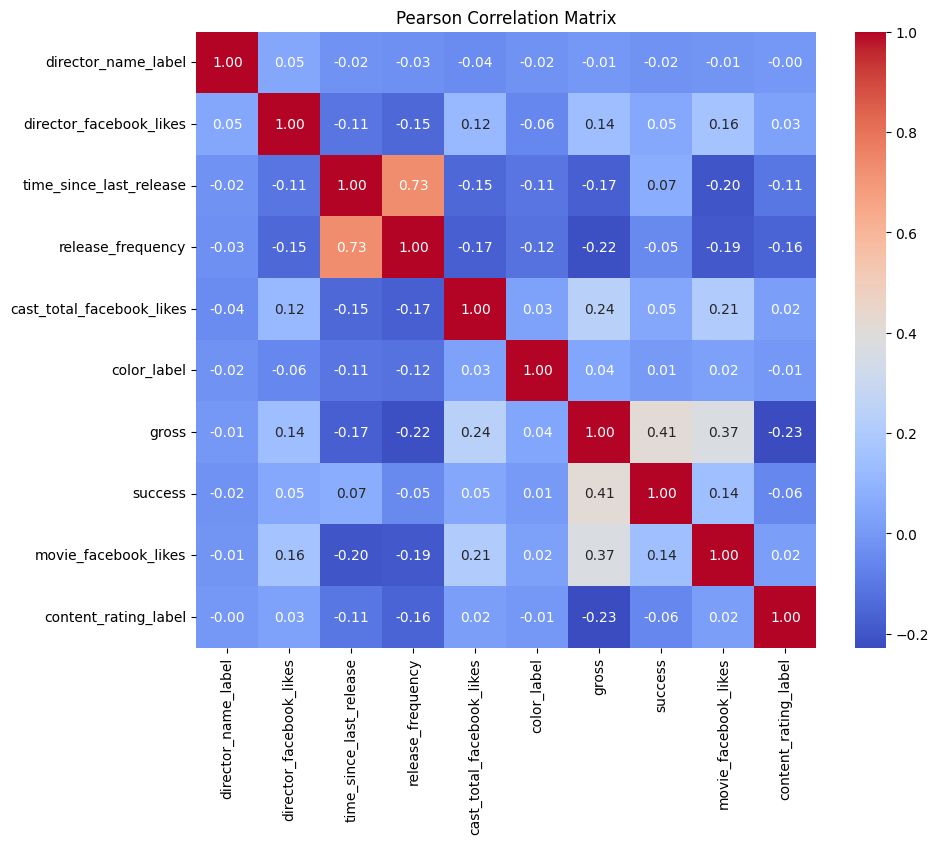

In [24]:
corr = data[features].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Pearson Correlation Matrix")
plt.show()

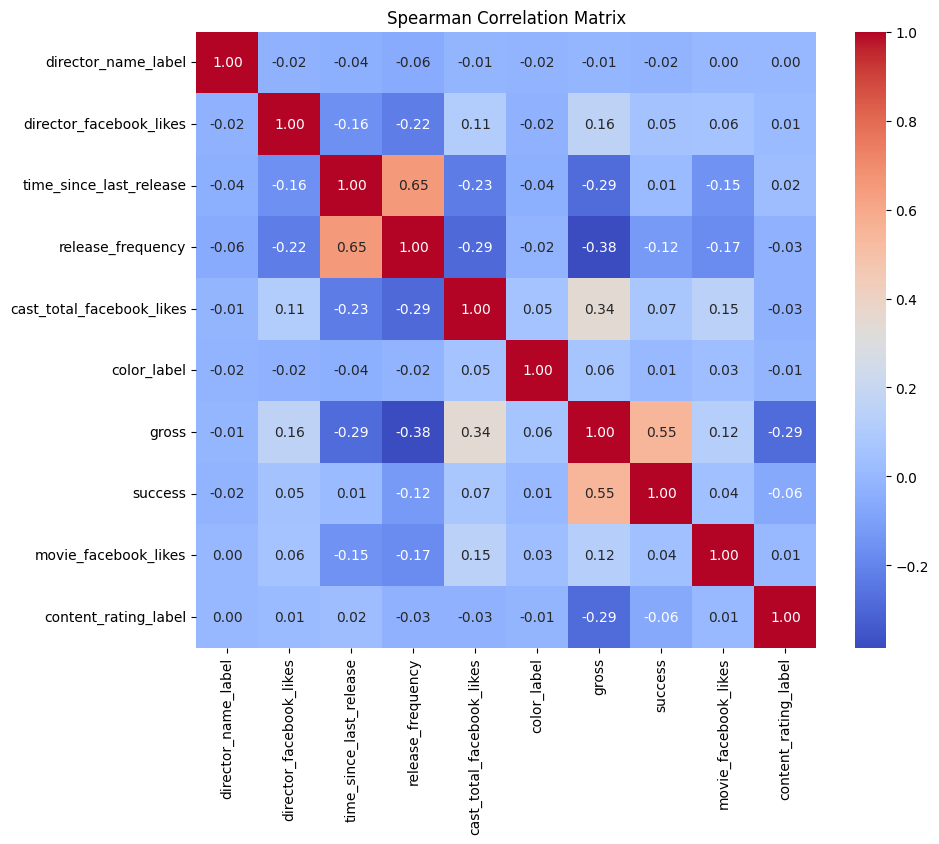

In [25]:
corr = data[features].corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman Correlation Matrix")
plt.show()

In [26]:
# Group movie years by director name
director_movie_years = df.groupby('director_name_label')['title_year'].apply(lambda x: sorted(x.unique())).to_dict()

print("Dictionary structure:")
print(director_movie_years)


Dictionary structure:
{0: [2009.0], 1: [2006.0], 2: [1996.0], 3: [2003.0], 4: [1993.0], 5: [2004.0, 2006.0, 2008.0, 2010.0, 2013.0, 2015.0], 6: [2005.0], 7: [1999.0], 8: [2001.0, 2002.0, 2003.0, 2005.0, 2007.0, 2008.0, 2012.0], 9: [1983.0, 1986.0, 1987.0, 2002.0], 10: [2007.0], 11: [2006.0], 12: [2009.0], 13: [2011.0], 14: [1954.0], 15: [2014.0], 16: [2012.0], 17: [1998.0], 18: [1993.0, 1997.0], 19: [1994.0], 20: [1996.0, 1999.0, 2003.0], 21: [2010.0], 22: [1999.0], 23: [1996.0], 24: [2013.0, 2015.0], 25: [1999.0], 26: [1993.0, 2001.0, 2010.0], 27: [2006.0], 28: [2001.0, 2004.0, 2009.0], 29: [2000.0, 2003.0, 2006.0, 2014.0, 2015.0], 30: [2006.0, 2015.0], 31: [2016.0], 32: [2012.0], 33: [2015.0], 34: [2007.0], 35: [2006.0, 2008.0, 2011.0], 36: [1994.0, 1998.0, 2004.0, 2009.0, 2016.0], 37: [2008.0], 38: [2002.0], 39: [1998.0], 40: [1999.0, 2002.0, 2004.0, 2011.0, 2013.0], 41: [2004.0], 42: [2003.0, 2006.0, 2008.0, 2010.0], 43: [2001.0, 2004.0, 2006.0, 2013.0], 44: [1960.0], 45: [1999.0],

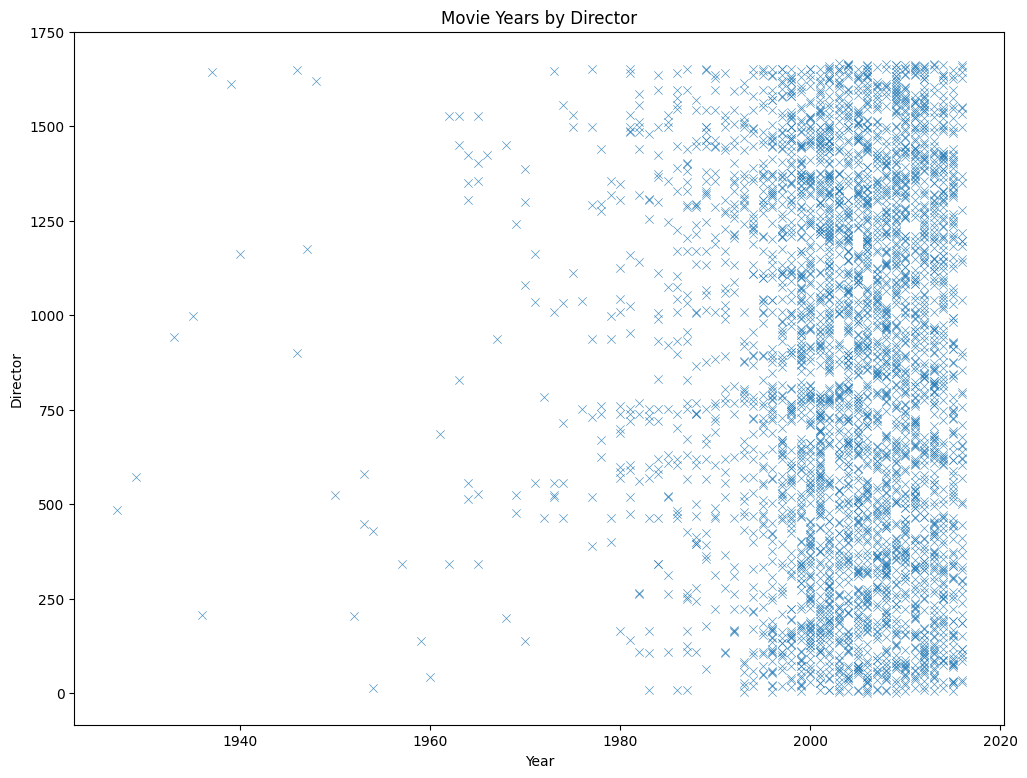

In [27]:
plot_data = pd.DataFrame([(director, year) for director, years in director_movie_years.items() for year in years], columns=['Director', 'Year'])

plt.figure(figsize=(12, 9))
sns.scatterplot(data=plot_data, x='Year', y='Director', marker='x', alpha=0.8)
plt.title('Movie Years by Director')
plt.xlabel('Year')
plt.ylabel('Director')
plt.show()

In [28]:
director_avg_year = df.groupby('director_name_label')['title_year'].mean().reset_index()


In [165]:
#
# AFTER FINDING A GOOD MODEL
#
director_avg_year = df.groupby('director_name_label')['title_year'].mean().reset_index()

# Make predictions for all directors
director_avg_year['predicted_movie_year'] = [round(predict_next_movie_year(director_name=_label, model=ada_model, df=df)[0])
                                              for _label in director_avg_year['director_name_label']]


e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
e:\Downloa

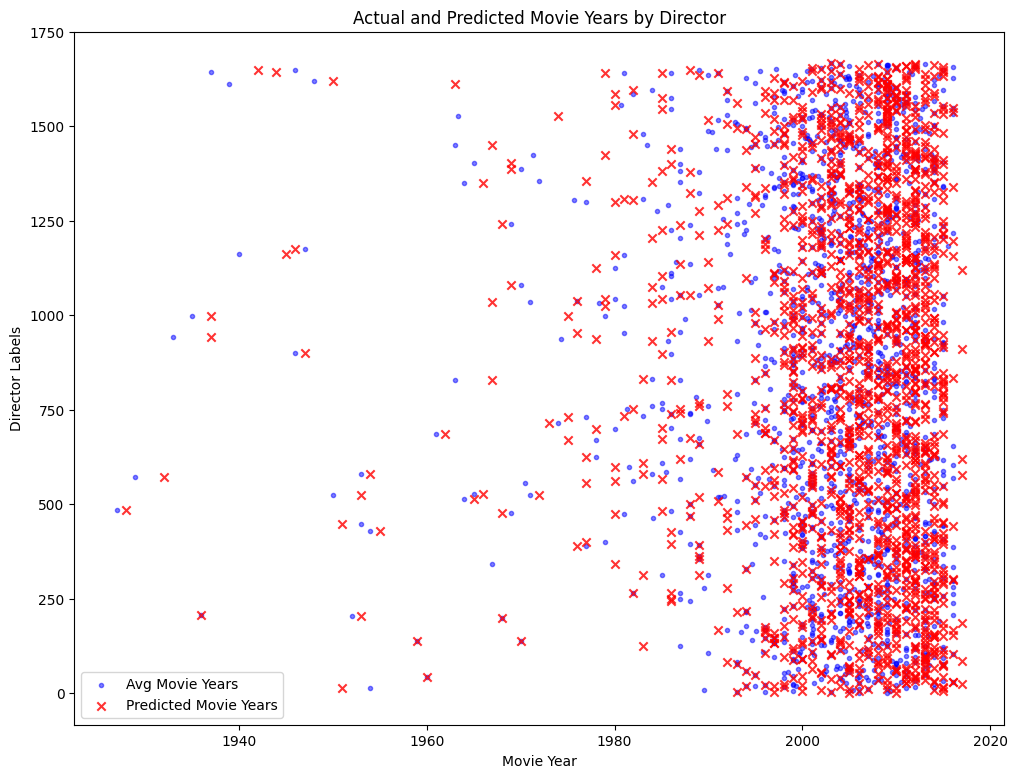

In [167]:
# Plot
plt.figure(figsize=(12, 9))
plt.scatter(director_avg_year['title_year'], director_avg_year['director_name_label'], label='Avg Movie Years', marker='.', color='blue', alpha = 0.5)
plt.scatter(director_avg_year['predicted_movie_year'], director_avg_year['director_name_label'], label='Predicted Movie Years', color='red', marker='x', alpha=0.8)
plt.xlabel('Movie Year')
plt.ylabel('Director Labels')
# plt.grid()
plt.title('Actual and Predicted Movie Years by Director')
plt.legend()
plt.show()

# ML

IMPORTS FOR ML


In [29]:
from sklearn.model_selection import train_test_split

# WE WILL BE TESTING THESE MODELS
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor  

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [30]:

def predict_next_movie_year(director_name, model, df, verbose = False):
    # EXTRACT FEATURES FROM DATAFRAME TO PASS IN THE MODEL
    director_data = df[df['director_name_label'] == director_name]
    if director_data.empty:
        print("Director not found in the dataset.")
        return None
    current_year = datetime.now().year
    last_movie_year = director_data['title_year'].max()
    time_since_last_release = current_year - last_movie_year if not pd.isnull(last_movie_year) else 0
    director_facebook_likes = director_data['director_facebook_likes'].max()
    release_frequency = director_data['release_frequency'].max()
    
    # EXTRACT LAST MOVIE'S INFORMATION
    last_movie = director_data.iloc[-1]
    last_movie_color = last_movie['color_label']
    success = last_movie['success']
    # content_rating_label = last_movie['content_rating_label']
    content_rating_label = director_data['content_rating_label'].value_counts().max()

    # ADD OTHER FEATURES IF REQUIRED
    
    # FEATURES 
    features = {
        'director_name_label': director_name,
        'director_facebook_likes': director_facebook_likes,
        'time_since_last_release': time_since_last_release,
        'release_frequency': release_frequency,
        'cast_total_facebook_likes': last_movie['cast_total_facebook_likes'],
        'color_label': last_movie_color,
        'gross': last_movie['gross'],
        'success': success,
        'movie_facebook_likes': last_movie['movie_facebook_likes'],
        'content_rating_label': content_rating_label
    }
    if verbose:
        print("Passed features - \n", features)
    
    # PREDICT NEXT MOVIE YEAR
    # next_movie_features = [features]
    next_movie_features = [list(features.values())]

    next_movie_year = model.predict(next_movie_features)
    
    return next_movie_year


def getDirector():
    name_to_label = processed_labels["director_name"]
    names = list(name_to_label.keys())
    labels = list(map(str, name_to_label.values()))

    _d = input("Enter a Director name or Label number : ").strip()
    if _d.lower() in [i.lower() for i in name_to_label.keys()]:
        return (_d, int(name_to_label[_d]))
    elif _d in labels:
        return (names[labels.index(_d)], int(_d))
    else: 
        print(f"Check name/number. We don't have the data for :'{_d}'")
        return ("", -1)

In [31]:
def convert_labels_to_genres(predicted_labels, genre_list):
    predicted_genres = []
    for i, label in enumerate(predicted_labels):
        if label == 1:
            predicted_genres.append(genre_list[i])
    return predicted_genres

def predict_next_movie_genre(director_name, model, model_for_year, df, verbose = False):
    # Extract additional features from the DataFrame
    director_data = df[df['director_name_label'] == director_name]
    if director_data.empty:
        print("Director not found in the dataset.")
        return None
    current_year = datetime.now().year
    last_movie_year = director_data['title_year'].max()
    time_since_last_release = current_year - last_movie_year if not pd.isnull(last_movie_year) else 0
    director_facebook_likes = director_data['director_facebook_likes'].max()
    release_frequency = director_data['release_frequency'].max()
    
    # Extract last movie's success and content rating label
    last_movie = director_data.iloc[-1]
    last_movie_color = last_movie['color_label']
    success = last_movie['success']
    # content_rating_label = last_movie['content_rating_label']
    content_rating_label = director_data['content_rating_label'].value_counts().max()

    
    # You can extract other features similarly
    
    # Create a dictionary containing the extracted features
    features = {
        'director_name_label': director_name,
        'director_facebook_likes': director_facebook_likes,
        'time_since_last_release': time_since_last_release,
        'release_frequency': release_frequency,
        'cast_total_facebook_likes': last_movie['cast_total_facebook_likes'],
        'color_label': last_movie_color,
        'gross': last_movie['gross'],
        'success': success,
        'movie_facebook_likes': last_movie['movie_facebook_likes'],
        'content_rating_label': content_rating_label
    }

    # Predict next movie year using the model used for year prediction
    next_movie_year = round(model_for_year.predict([list(features.values())])[0])
    features['title_year'] = next_movie_year
    if verbose:
        print("Passed features - \n", features)
    

    next_movie_features = [list(features.values())]
    next_movie_genre = model.predict(next_movie_features)
    
    return next_movie_genre[0]


### YEAR PREDICITION

SELECTING RELEVANT DATA AND SPLITTING IT FOR TRAIN AND TEST

In [32]:
# Split data into features and target variable
X = data[features]
y = data[target].astype(np.int64)


In [33]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2525, 10) (1244, 10) (2525,) (1244,)


In [34]:
# Group movie years by director name
director_movie_years = df.groupby('director_name_label')['title_year'].apply(lambda x: sorted(x.unique())).to_dict()

print("Dictionary structure:")
print(director_movie_years)

Dictionary structure:
{0: [2009.0], 1: [2006.0], 2: [1996.0], 3: [2003.0], 4: [1993.0], 5: [2004.0, 2006.0, 2008.0, 2010.0, 2013.0, 2015.0], 6: [2005.0], 7: [1999.0], 8: [2001.0, 2002.0, 2003.0, 2005.0, 2007.0, 2008.0, 2012.0], 9: [1983.0, 1986.0, 1987.0, 2002.0], 10: [2007.0], 11: [2006.0], 12: [2009.0], 13: [2011.0], 14: [1954.0], 15: [2014.0], 16: [2012.0], 17: [1998.0], 18: [1993.0, 1997.0], 19: [1994.0], 20: [1996.0, 1999.0, 2003.0], 21: [2010.0], 22: [1999.0], 23: [1996.0], 24: [2013.0, 2015.0], 25: [1999.0], 26: [1993.0, 2001.0, 2010.0], 27: [2006.0], 28: [2001.0, 2004.0, 2009.0], 29: [2000.0, 2003.0, 2006.0, 2014.0, 2015.0], 30: [2006.0, 2015.0], 31: [2016.0], 32: [2012.0], 33: [2015.0], 34: [2007.0], 35: [2006.0, 2008.0, 2011.0], 36: [1994.0, 1998.0, 2004.0, 2009.0, 2016.0], 37: [2008.0], 38: [2002.0], 39: [1998.0], 40: [1999.0, 2002.0, 2004.0, 2011.0, 2013.0], 41: [2004.0], 42: [2003.0, 2006.0, 2008.0, 2010.0], 43: [2001.0, 2004.0, 2006.0, 2013.0], 44: [1960.0], 45: [1999.0],

                                
PARAMETERS WERE TUNED TO GET LOW ERROR

In [35]:
# -------------- GOT ------------------
# Mean Squared Error: 25.893096327562287
# Mean Absolute Error: 3.114650072942316
# R-squared: 0.745974194568207

# Initialize and train the model
rf_model = RandomForestRegressor( 
                                max_depth=350, 
                                n_jobs=8,
                                # max_features='sqrt',
                                max_features="log2",
                                max_leaf_nodes=350, 
                                n_estimators=250,
                                criterion='poisson',
                                # criterion='absolute_error',
                                # criterion='friedman_mse'
                              ) 

rf_model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = rf_model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Squared Error: 25.70810096828922
Mean Absolute Error: 3.11349497017109
R-squared: 0.7477891028567327


In [39]:
# director_name = 'Chris Columbus'
director_name, director_label = [i for i in [getDirector()] if len(i[0]) > 0][0]
predicted_year = predict_next_movie_year(director_label, rf_model, df)
print(f"Predicted next movie year for {director_name} : {round(predicted_year[0])}")

print(f"historical data : {director_movie_years[director_label]}")

Predicted next movie year for Chris Columbus : 2012
historical data : [1990.0, 1992.0, 1993.0, 1998.0, 1999.0, 2001.0, 2002.0, 2005.0, 2009.0, 2010.0, 2015.0]


e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [40]:
# ------------- GOT --------------------
# Mean Squared Error: 21.869246384571696
# Mean Absolute Error: 2.844392783900462
# R-squared: 0.785450420577408

# Initialize and train the model
gbr_model = GradientBoostingRegressor(  
                                    n_estimators=2000, 
                                    learning_rate=0.03, 
                                    max_depth=7,
                                    # max_features='sqrt',
                                    max_features = 'log2',
                                    max_leaf_nodes=30,
                                  )
gbr_model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = gbr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Squared Error: 22.026474592173322
Mean Absolute Error: 2.863532904610186
R-squared: 0.7839079236289034


In [41]:
# director_name = 'Chris Columbus'
director_name, director_label = [i for i in [getDirector()] if len(i[0]) > 0][0]
predicted_year = predict_next_movie_year(director_label, gbr_model, df)
print(f"Predicted next movie year for {director_name} : {round(predicted_year[0])}")

print(f"historical data : {director_movie_years[director_label]}")

Predicted next movie year for Chris Columbus : 2013
historical data : [1990.0, 1992.0, 1993.0, 1998.0, 1999.0, 2001.0, 2002.0, 2005.0, 2009.0, 2010.0, 2015.0]


e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [42]:
# ------------- GOT ------------------
# Mean Squared Error: 103.51094149694111
# Mean Absolute Error: 7.0811976674348065
# R-squared: -0.015500423438125077

# svr_model = SVR(kernel='linear', max_iter=10000) 
# svr_model = SVR(kernel='poly')
svr_model = SVR(kernel='rbf')

svr_model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = svr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)


Mean Squared Error: 103.51094149694111
Mean Absolute Error: 7.0811976674348065
R-squared: -0.015500423438125077


In [43]:
# director_name = 'Chris Columbus'
director_name, director_label = [i for i in [getDirector()] if len(i[0]) > 0][0]
predicted_year = predict_next_movie_year(director_label, svr_model, df)
print(f"Predicted next movie year for {director_name} : {round(predicted_year[0])}")

print(f"historical data : {director_movie_years[director_label]}")

Predicted next movie year for Chris Columbus : 2005
historical data : [1990.0, 1992.0, 1993.0, 1998.0, 1999.0, 2001.0, 2002.0, 2005.0, 2009.0, 2010.0, 2015.0]


e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [44]:
# --------------- GOT --------------------
# Mean Squared Error: 22.93437696089338
# Mean Absolute Error: 2.9781402987810384
# R-squared: 0.7750008919031516

reg_1 = GradientBoostingRegressor(  
                                    n_estimators=1000, 
                                    learning_rate=0.03, 
                                    max_depth=5,
                                    max_features='sqrt',
                                    # max_features = 'log2',
                                    max_leaf_nodes=10,
                                  )

rng = np.random.RandomState(1)
ada_model = AdaBoostRegressor(
                            reg_1, 
                            n_estimators=10, 
                            random_state=rng,
                            learning_rate= 0.03,
                            loss='square',
                            )

# model = reg_1
ada_model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = ada_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Squared Error: 22.93437696089338
Mean Absolute Error: 2.9781402987810384
R-squared: 0.7750008919031516


In [46]:
# director_name = 'Chris Columbus'
director_name, director_label = [i for i in [getDirector()] if len(i[0]) > 0][0]
predicted_year = predict_next_movie_year(director_label, ada_model, df)
print(f"Predicted next movie year for {director_name} : {round(predicted_year[0])}")

print(f"historical data : {director_movie_years[director_label]}")

Predicted next movie year for Chris Columbus : 2013
historical data : [1990.0, 1992.0, 1993.0, 1998.0, 1999.0, 2001.0, 2002.0, 2005.0, 2009.0, 2010.0, 2015.0]


e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


### PREDICTING GENRE

In [47]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, f1_score


In [48]:
target = new_genre_columns

data_with_genre = df[features + new_genre_columns + ['title_year']].copy()

In [49]:
data_with_genre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3769 entries, 3497 to 3678
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   director_name_label        3769 non-null   int64  
 1   director_facebook_likes    3769 non-null   float64
 2   time_since_last_release    3769 non-null   float64
 3   release_frequency          3769 non-null   float64
 4   cast_total_facebook_likes  3769 non-null   int64  
 5   color_label                3769 non-null   int64  
 6   gross                      3769 non-null   float64
 7   success                    3769 non-null   int32  
 8   movie_facebook_likes       3769 non-null   int64  
 9   content_rating_label       3769 non-null   int64  
 10  Action                     3769 non-null   int64  
 11  Adventure                  3769 non-null   int64  
 12  Animation                  3769 non-null   int64  
 13  Biography                  3769 non-null   int64  

In [51]:
X_genre = data_with_genre[features + ['title_year']]
y_genre = data_with_genre[target]

In [52]:
# Split the data into training and testing sets
X_train_genre, X_test_genre, y_train_genre, y_test_genre = train_test_split(X_genre, y_genre, test_size=0.3, random_state=42)

print(X_train_genre.shape, X_test_genre.shape, y_train_genre.shape, y_test_genre.shape)


(2638, 11) (1131, 11) (2638, 22) (1131, 22)


In [53]:
# Train a multi-label classification model
rf_multi_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=1000,
                                                             max_depth=20,
                                                            random_state=42),
                                                            n_jobs=8)
rf_multi_model.fit(X_train_genre, y_train_genre)

# Predict labels for the test set
y_pred_genre = rf_multi_model.predict(X_test_genre)

# Evaluate the model
accuracy = rf_multi_model.score(X_test_genre, y_test_genre)
print("Model Accuracy:", accuracy)

# Evaluate the model
accuracy = rf_multi_model.score(X_test_genre, y_test_genre)
print("Model Accuracy:", accuracy)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_genre, y_pred_genre, average='weighted')
recall = recall_score(y_test_genre, y_pred_genre, average='weighted')
f1 = f1_score(y_test_genre, y_pred_genre, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Model Accuracy: 0.07869142351900972
Model Accuracy: 0.07869142351900972
Precision: 0.651250966451616
Recall: 0.3076241134751773
F1 Score: 0.3639302093743225


e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
director_name = 222
predicted_genres = convert_labels_to_genres(predict_next_movie_genre(director_name, 
                                                                     rf_multi_model, 
                                                                     model_for_year= ada_model,
                                                                     df = df, verbose = 1), new_genre_columns)
print("Predicted Genres for the Next Movie(s):", predicted_genres)

e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


Passed features - 
 {'director_name_label': 222, 'director_facebook_likes': 0.0, 'time_since_last_release': 9.0, 'release_frequency': 5.363636363636363, 'cast_total_facebook_likes': 35367, 'color_label': 1, 'gross': 78747585.0, 'success': 0, 'movie_facebook_likes': 39000, 'content_rating_label': 6, 'title_year': 2013}
Predicted Genres for the Next Movie(s): ['Adventure', 'Family', 'Fantasy']


In [59]:
inner = AdaBoostClassifier(n_estimators=500, learning_rate=0.3, random_state=42)

# Train a multi-label classification model
ada_multi_model = MultiOutputClassifier(inner, n_jobs=4)
ada_multi_model.fit(X_train_genre, y_train_genre)

# Predict labels for the test set
y_pred_genre = ada_multi_model.predict(X_test_genre)

# Evaluate the model
accuracy = ada_multi_model.score(X_test_genre, y_test_genre)
print("Model Accuracy:", accuracy)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_genre, y_pred_genre, average='weighted')
recall = recall_score(y_test_genre, y_pred_genre, average='weighted')
f1 = f1_score(y_test_genre, y_pred_genre, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Model Accuracy: 0.05481874447391689
Precision: 0.5375583671850533
Recall: 0.2993498817966903
F1 Score: 0.3480061420509432


e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
director_name = 222
predicted_genres = convert_labels_to_genres(predict_next_movie_genre(director_name, 
                                                                     ada_multi_model, 
                                                                     model_for_year= ada_model,
                                                                     df = df, verbose = 1), new_genre_columns)
print("Predicted Genres for the Next Movie(s):", predicted_genres)

e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


Passed features - 
 {'director_name_label': 222, 'director_facebook_likes': 0.0, 'time_since_last_release': 9.0, 'release_frequency': 5.363636363636363, 'cast_total_facebook_likes': 35367, 'color_label': 1, 'gross': 78747585.0, 'success': 0, 'movie_facebook_likes': 39000, 'content_rating_label': 6, 'title_year': 2013}
Predicted Genres for the Next Movie(s): ['Adventure', 'Family']


In [58]:
_director_data = df[df['director_name_label'] == 222]
_director_data[['title_year', 'title_year_DateStamp', 'time_since_last_release', 'genres']]

,title_year,title_year_DateStamp,time_since_last_release,genres
2601,1990.0,1990-01-01,34.0,Comedy|Family
2153,1992.0,1992-01-01,2.0,Adventure|Comedy|Family
1867,1993.0,1993-01-01,1.0,Comedy|Drama|Family|Romance
943,1998.0,1998-01-01,5.0,Comedy|Drama
385,1999.0,1999-01-01,1.0,Comedy|Drama|Sci-Fi
202,2001.0,2001-01-01,2.0,Adventure|Family|Fantasy
285,2002.0,2002-01-01,1.0,Adventure|Family|Fantasy|Mystery
1273,2005.0,2005-01-01,3.0,Drama|Musical|Romance
2436,2009.0,2009-01-01,4.0,Comedy|Romance
351,2010.0,2010-01-01,1.0,Adventure|Family|Fantasy
